In [1]:
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from PIL import Image, ImageOps
import lime
import lime.lime_tabular

In [2]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

df = df[df['make_playoffs'] == 1]
print(list(df.columns))

['Season', 'Team', 'team_id', 'conference', 'divisions', 'round', 'champion_share', 'champion', 'W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP'

In [3]:
data_columns = ['W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs',
                'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 
                'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 
                'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp',
                'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 
                'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A',
                'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%',
                'team_offense_TO%', 'team_offense_EXP', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply',
                'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
                'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 
                'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 
                'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 
                'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP',
                'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 
                'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C',
                'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 
                'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP', 'pso', 'over500_rec', 'over600_rec', 'rec_7pt_or_less', 
                'sum_games_7pts_or_less', 'over500_PD', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_opoy_shares', 'sum_all_pro', 'sum_cpoy_shares', 
                'sum_champion_shares', 'sum_champions', 'sum_playoff_games', 'sum_mvp_shares_L4S', 'sum_dpoy_shares_L4S', 'sum_player_L1S_cs',
                'sum_player_L3S_cs', 'sum_player_L5S_cs', 'sum_player_L8S_cs', 'conference_record', 'divisions_record', 'sum_coach_playoff_games',
                'sum_kicker_playoff_games', '40_50+_perc_x_makes', 'Scoring_FG%', 'Scoring_Lng', 'Scoring_XP%', 'break_even_over500_PD', 
                'sum_QB_playoff_games', 'QB_Age', 'sum_QB_mvp_shares', 'sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs', 'team_rating_custom', 'QB_2_or_more_GWD', '500_rec_7pt_or_less', '625_rec',  'SRS_greater_than_1.5_pts', 'team_rating_custom', 'rank_team_rating_custom', 'top_5_team_rating_custom']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [4]:
correlation_matrix = data.corr()

correlation_threshold = .75

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

In [5]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'W', 'PF', 'PA', 'PD', 'SoS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Passing_NY/A', 'team_offense_Passing_Att', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_EXP', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Passing_TD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_1stPy', 'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp%', 'passing_offense_TD%', 'passing_offense_Lng', 'passing_offense_Y/C'

In [106]:
features = ['40_50+_perc_x_makes', 'sum_kicker_playoff_games', 'sum_QB_playoff_games', 'top_5_team_rating_custom', 
           'sum_coach_playoff_games', 'sum_dpoy_shares', 'sum_cpoy_shares', 'sum_champions', 'sum_all_pro', 'sum_QB_mvp_shares',
            
            'SoS', 'pso',
           'team_offense_Tot Yds & TO_TO', 'team_offense_Passing_Att', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Penalties_Pen' , 'team_offense_Penalties_1stPy',
            'team_defense_Tot Yds & TO_Ply', 'team_defense_Rushing_Yds', 'passing_offense_Lng', 'passing_offense_Y/C',
            'passing_offense_Sk', 'passing_offense_4QC', 'sum_mvp_shares', 'DSRS', 'OSRS', 'QB_Age',
           
             'team_defense_EXP', 'sum_playoff_games', 'team_offense_EXP', 'sum_opoy_shares', 'sum_player_L3S_cs','500_rec_7pt_or_less', 'SRS', 'sum_franchise_L1S_cs'
           ]

            
num_features = len(features)

print(f"Number of features: {num_features}")



Number of features: 36


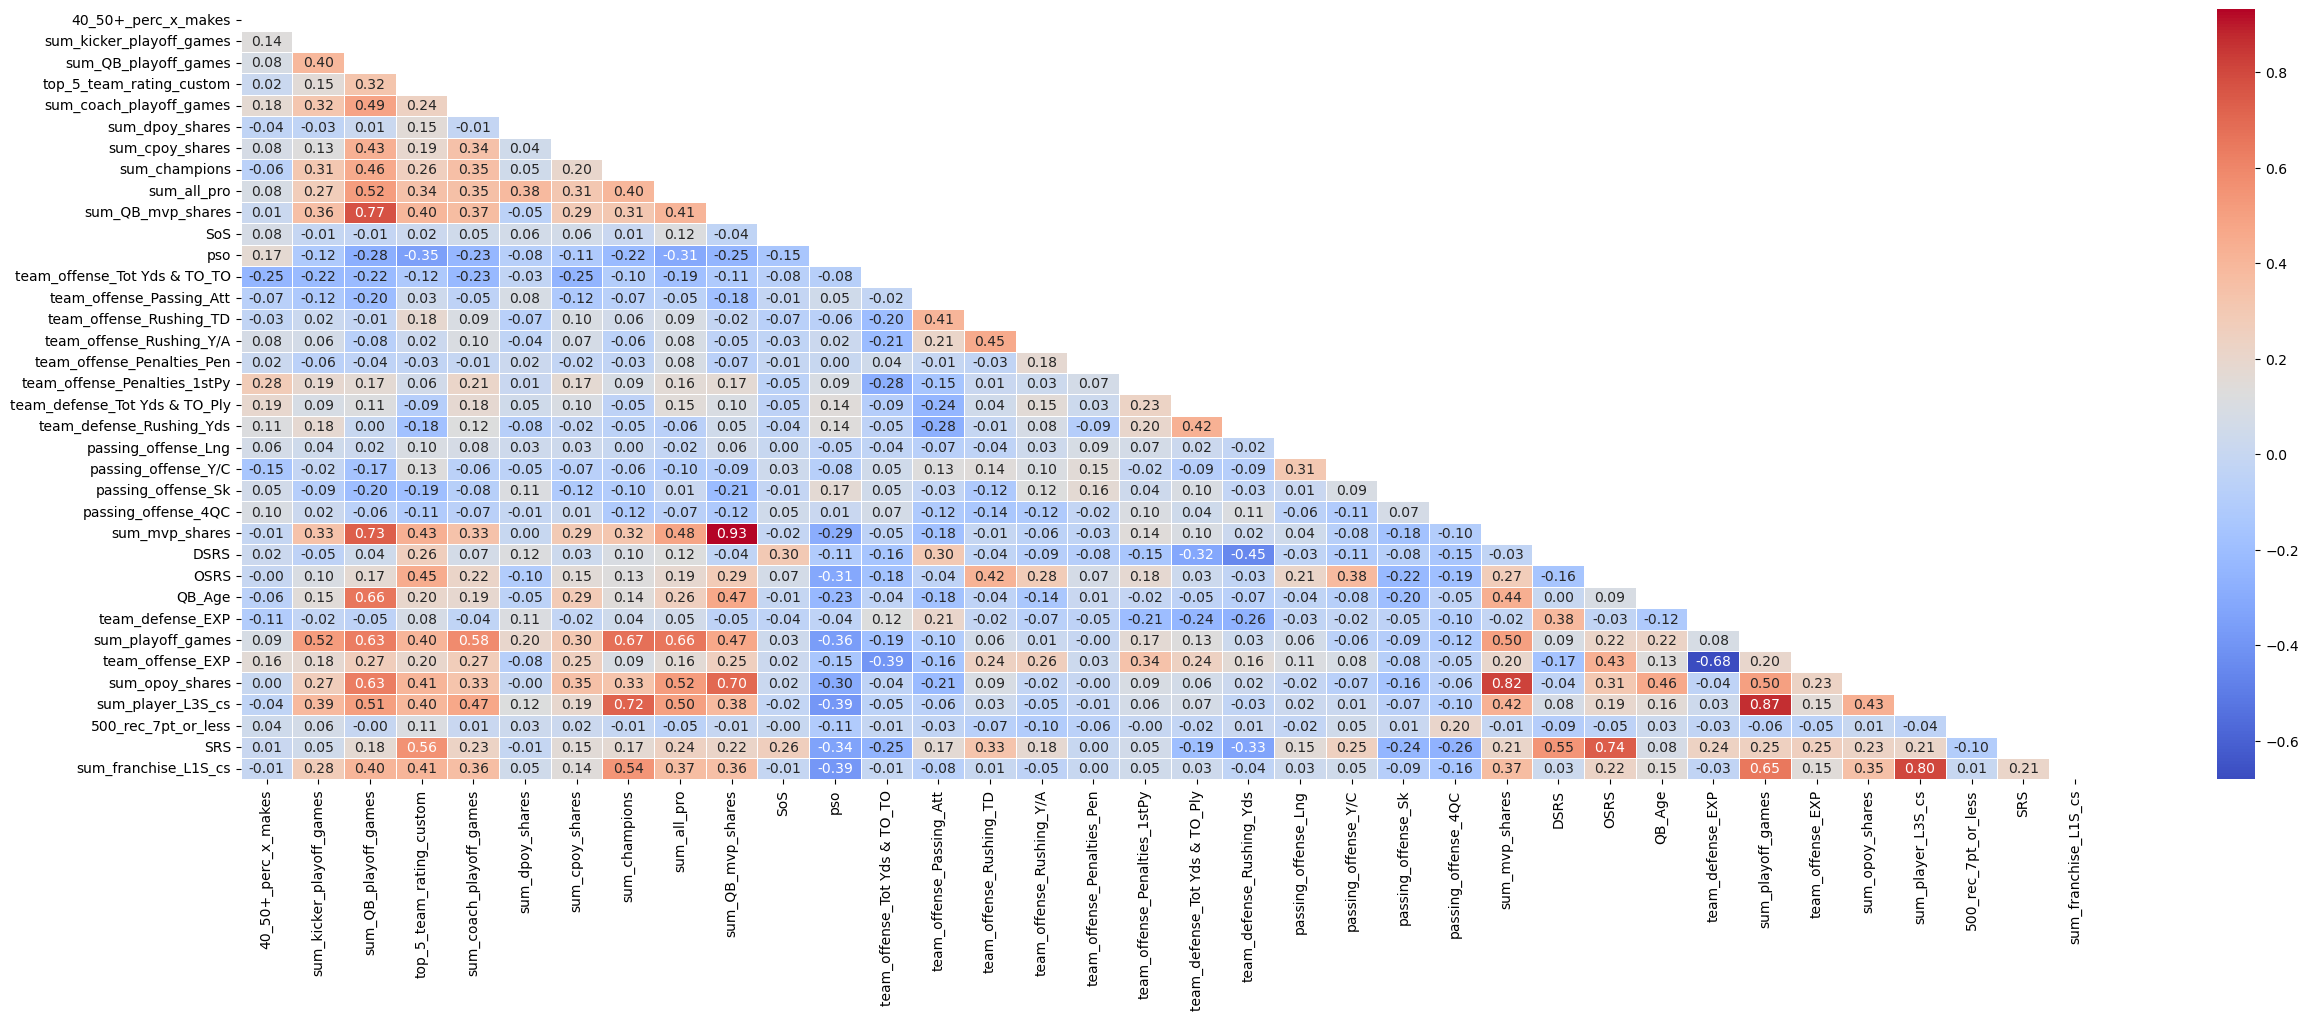

In [107]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

### Ridge Regression:

Results:

    Season                  Team  champion_share  predicted_cs
14    2024   San Francisco 49ers            0.75      0.686345
21    2024      Baltimore Ravens            0.50      0.645062
8     2024    Kansas City Chiefs            1.00      0.411539
9     2024         Buffalo Bills            0.25      0.402795
15    2024        Dallas Cowboys            0.00      0.373397
0     2024      Cleveland Browns            0.00      0.325610
11    2024        Miami Dolphins            0.00      0.287851
10    2024   Philadelphia Eagles            0.00      0.263967
1     2024      Los Angeles Rams            0.00      0.175299
13    2024         Detroit Lions            0.50      0.152504
19    2024        Houston Texans            0.25      0.058800
27    2024     Green Bay Packers            0.25      0.042082
30    2024  Tampa Bay Buccaneers            0.25      0.029476
2     2024   Pittsburgh Steelers            0.00      0.028944
---------------------------------------------

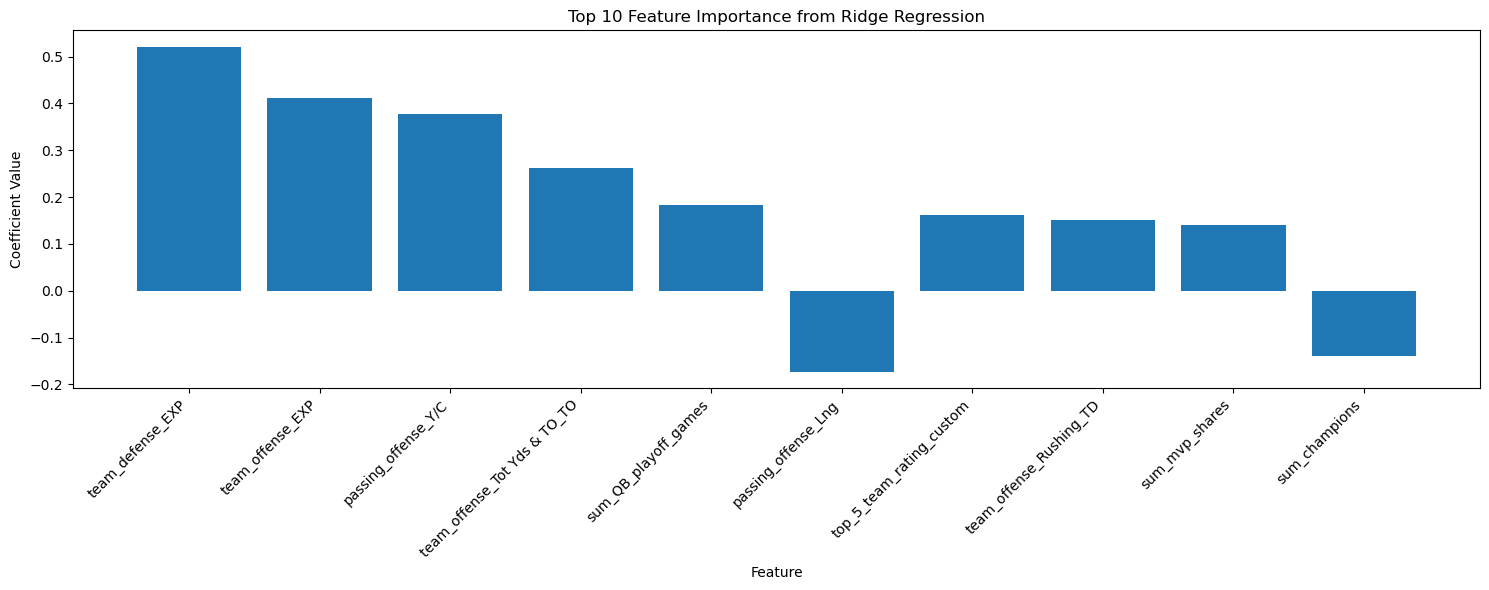

In [108]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

df = df[df['make_playoffs'] == 1]

df.drop(df[df['Season'] < 2005].index, inplace=True)

test_season = 2024

train = df[df["Season"] < test_season].copy()
test = df[df["Season"] == test_season].copy()


sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rig = Ridge(alpha=0.5)
rig.fit(train[features], train["champion_share"])

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(14))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k)

ndcg_score_true = calculate_ndcg(frame, k=14)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

coefficients = rig.coef_
feature_coefficients = dict(zip(features, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

top_features = sorted_feature_coefficients[:10]
features_names = [x[0] for x in top_features]
coeff_values = [x[1] for x in top_features]

plt.figure(figsize=(15, 6))
plt.bar(features_names, coeff_values)
plt.title('Top 10 Feature Importance from Ridge Regression')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
rig_reg_frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
rig_reg_frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

In [109]:
actual = frame.sort_values("champion_share", ascending=False)
predicted = frame.sort_values("predicted_cs", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame):
    actual = frame.sort_values("champion_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("predicted_cs", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x                Team  champion_share_x  predicted_cs_x  Rank  Season_y  champion_share_y  predicted_cs_y  Predicted Rank
0      2024  Kansas City Chiefs               1.0        0.411539     1      2024               1.0        0.411539               3

AP Champion:  0.3333333333333333


In [110]:
rig_reg_combined_predictions = pd.DataFrame(columns=["Season","Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

#backtest_seasons = [2023,2022,2021,2020]
backtest_seasons = [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015]

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rig.fit(train[features], train['champion_share'])
    predictions = rig.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)

    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    rig_reg_combined_predictions = pd.concat([rig_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

rig_reg_combined_predictions.to_csv("rig_reg_nfl_preds.csv", index=False)

Champion AP for Season 2024: 0.33 | Reciprocal: 3.0 | NDCG: 0.88
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0 | NDCG: 0.99
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0 | NDCG: 0.79
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0 | NDCG: 0.89
Champion AP for Season 2020: 0.5 | Reciprocal: 2.0 | NDCG: 0.73
Champion AP for Season 2019: 1.0 | Reciprocal: 1.0 | NDCG: 0.89
Champion AP for Season 2018: 0.5 | Reciprocal: 2.0 | NDCG: 0.89
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0 | NDCG: 0.98
Champion AP for Season 2016: 1.0 | Reciprocal: 1.0 | NDCG: 0.97
Champion AP for Season 2015: 0.33 | Reciprocal: 3.0 | NDCG: 0.79

Top 5 Predicted Teams for Season 2024:
                   Team  predicted_cs  champion_share
14  San Francisco 49ers      0.686345            0.75
21     Baltimore Ravens      0.645062            0.50
8    Kansas City Chiefs      0.411539            1.00
9         Buffalo Bills      0.402795            0.25
15       Dallas Cowboys      0.373397           

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Top 10 Features:
['team_defense_EXP', 'top_5_team_rating_custom', 'OSRS', 'sum_coach_playoff_games', 'passing_offense_Sk', 'team_defense_Rushing_Yds', 'passing_offense_Y/C', 'sum_playoff_games', 'team_defense_Tot Yds & TO_Ply', 'passing_offense_Lng']


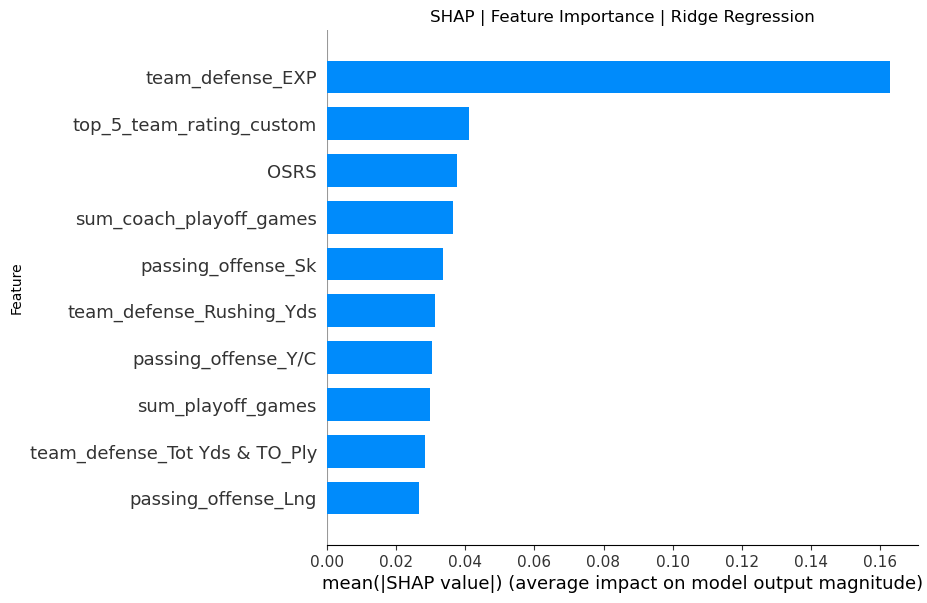

In [111]:

explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)
plt.title('SHAP | Feature Importance | Ridge Regression')

plt.savefig("ridge_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ridge_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ridge_shap_bar.png")

plt.ylabel("Feature")
plt.show()

Top 10 Features:
['team_defense_EXP', 'top_5_team_rating_custom', 'OSRS', 'sum_coach_playoff_games', 'passing_offense_Sk', 'team_defense_Rushing_Yds', 'passing_offense_Y/C', 'sum_playoff_games', 'team_defense_Tot Yds & TO_Ply', 'passing_offense_Lng']


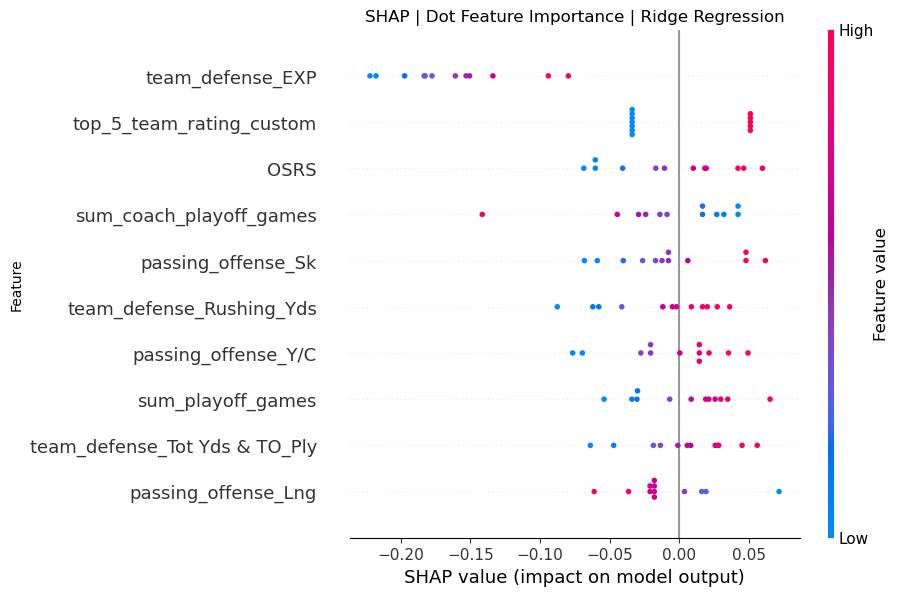

In [112]:
explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | Ridge Regression')

plt.savefig("rig_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rig_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rig_shap_dot.png")

plt.ylabel("Feature")
plt.show()